In [25]:
from transformers import BertForSequenceClassification
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class MixedLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, pos_weight=None, mix_ratio=0.5):
        super(MixedLoss, self).__init__()
        self.focal_loss = FocalLoss(weight=weight, gamma=gamma, reduction="mean").to(device)
        self.bce_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
        self.mix_ratio = mix_ratio

    def forward(self, inputs, targets):
        loss_focal = self.focal_loss(inputs, targets)
        loss_bce = self.bce_loss(inputs, targets)
        return (self.mix_ratio * loss_focal) + ((1 - self.mix_ratio) * loss_bce)


class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2., reduction='none'):
        super(FocalLoss, self).__init__()
        self.weight = weight.to(device)
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        BCE_loss = BCE_loss.to(device)
        pt = torch.exp(-BCE_loss)
        F_loss = self.weight * ((1 - pt) ** self.gamma) * BCE_loss

        if self.reduction == 'sum':
            return torch.sum(F_loss)
        elif self.reduction == 'mean':
            return torch.mean(F_loss)
        else:
            return F_loss


In [3]:
from transformers import BertForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class BERTMultiLabelBinaryClassification_FactorLoss(torch.nn.Module):
    def __init__(self, num_labels, label_weight, gamma=2.0, mix_ratio=0.5):
        super(BERTMultiLabelBinaryClassification_FactorLoss, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
        self.label_weight = torch.tensor(label_weight)
        self.gamma = gamma
        self.mixed_loss = MixedLoss(weight=self.label_weight, gamma=self.gamma, pos_weight=self.label_weight,
                                    mix_ratio=mix_ratio).to(device)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        if labels is not None:
            loss = self.mixed_loss(logits.view(-1, self.bert.config.num_labels),
                                   labels.view(-1, self.bert.config.num_labels))
            return loss
        else:
            return logits


class BERTMultiLabelBinaryClassification(torch.nn.Module):
    def __init__(self, num_labels, label_weight):
        super(BERTMultiLabelBinaryClassification, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
        self.label_weight = label_weight

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        if labels is not None:
            pos_weight = torch.tensor(self.label_weight)
            pos_weight.to(device)
            loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
            loss_fct.to(device)
            loss = loss_fct(logits.view(-1, self.bert.config.num_labels), labels.view(-1, self.bert.config.num_labels))
            return loss
        else:
            return logits


In [4]:
def classify(question):
    load_model_name = "./model_state_dict_all_data_1.pth"
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BERTMultiLabelBinaryClassification_FactorLoss(num_labels=6, gamma=2.5,
                                                          mix_ratio=0.3, label_weight=[0, 0, 0, 0, 0, 0])
    model.load_state_dict(torch.load(load_model_name, map_location=device))

    sentence_encodings = tokenizer(question, truncation=True, padding=True, max_length=128)
    sentence_seq = torch.tensor(sentence_encodings['input_ids'])
    sentence_mask = torch.tensor(sentence_encodings['attention_mask'])
    model.eval()
    with torch.no_grad():
        model.cpu()
        inputs = {
            'input_ids': sentence_seq.unsqueeze(0),
            'attention_mask': sentence_mask.unsqueeze(0)
        }
        outputs = model(**inputs)
        logits = torch.sigmoid(outputs).detach().cpu().numpy()

    pred_labels = (logits > 0.5).astype(int)
    return pred_labels[0]

In [6]:
import math
import random
import pandas as pd
import spacy
import yake
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from typing import List
from tqdm import tqdm

nlp = spacy.load("en_core_web_sm")
kw_extractor = yake.KeywordExtractor(n=1,
                                     dedupLim=0.9,
                                     top=10,
                                     features=None)


class BM25:
    def __init__(self, corpus: List[List[str]], k1=1.5, b=0.95):
        self.corpus = corpus
        self.k1 = k1
        self.b = b
        self.documents_number = len(corpus)
        self.avgdl = sum(len(document) for document in corpus) / self.documents_number
        self.df = self._calculate_df()
        self.idf = self._calculate_idf()

    def _calculate_df(self):
        df = {}
        for document in self.corpus:
            for word in set(document):
                df[word] = df.get(word, 0) + 1
        return df

    def _calculate_idf(self):
        idf = {}
        for word, freq in self.df.items():
            idf[word] = math.log((self.documents_number - freq + 0.5) / (freq + 0.5) + 1)
        return idf

    def _score(self, document, query):
        score = 0.0
        for word in query:
            if word in self.df:
                idf = self.idf[word]
                term_freq = document.count(word)
                score += (idf * term_freq * (self.k1 + 1)) / (
                        term_freq + self.k1 * (1 - self.b + self.b * len(document) / self.avgdl))
        return score

    def get_scores(self, query):
        scores = []
        for index, document in enumerate(self.corpus):
            score = self._score(document, query)
            scores.append((index, score))
        return scores

In [20]:
def search(query: str, keywords, bm25, top_k, df):    
    tokenized_query = query.split()
    tokenized_query.extend(keywords)
    scores = bm25.get_scores(tokenized_query)
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)[:top_k]
    result = {}
    for doc_index, score in sorted_scores:
        pmid = df.iloc[doc_index]['PMID']
        result[pmid] = score
    return list(result.keys())

In [8]:
def search_bm25(query: str, bm25, top_k):
    global df
    tokenized_query = query.split()
    scores = bm25.get_scores(tokenized_query)
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)[:top_k]
    result = {}
    for doc_index, score in sorted_scores:
        pmid = df.iloc[doc_index]['PMID']
        result[pmid] = score
    return list(result.keys())

In [9]:
def extract_keywords(text):
    keywords = kw_extractor.extract_keywords(text)
    keywords_set = {word for word, _ in keywords}
    return list(set(keywords_set))


def query_pre_process(query):
    proper_nouns = extract_keywords(query)
    proper_nouns = [word for word in proper_nouns if word.lower() not in ENGLISH_STOP_WORDS] * 1
    return proper_nouns

In [38]:
df = pd.read_csv('./PubmedDataSet.csv')
texts = df['Abstract'].tolist()
tokenized_texts = [doc.split() for doc in texts]
bm25_abstract = BM25(tokenized_texts)
# 准备测试数据
df_test = pd.read_csv('./evaluation.csv')
df2 = pd.read_csv('./splitted_pubmed_data_NLTK.csv')
test = []


for index, row in df_test.iterrows():
    small_list = [row["Question"], row["PMID"]]
    test.append(small_list)
# random.seed(42)
random.shuffle(test)
test = test[:50]

In [40]:
t = 0
for query, pmid in tqdm(test):
    top_pmids = search_bm25(query, bm25_abstract, 3)
    if pmid in top_pmids:
        t += 1
print(f'recall of bm25 {t / len(test)}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:39<00:00,  1.99s/it]

recall of bm25 0.78


In [44]:
t = 0
for query, pmid in tqdm(test):
    keywords = query_pre_process(query)
    result_pmids_scores = search(query, keywords, bm25_abstract, 20, df)
    mask = df2['PMID'].isin(result_pmids_scores)
    df_t = df2[mask]
    texts = df_t['chunk_text'].tolist()
    tokenized_texts = [doc.split() for doc in texts]

    bm25_chunk = BM25(tokenized_texts)
    result_pmids_scores = search(query, keywords, bm25_chunk, 3, df_t)
    if pmid in result_pmids_scores:
        t += 1
print(f'recall of bm25 {t / len(test)}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:21<00:00,  2.83s/it]

recall of bm25 0.8


In [41]:
Q = len(test)
MRR = 0
for query, pmid in tqdm(test):
    top_pmids = search_bm25(query, bm25_abstract, 3)
    try:
        rank = top_pmids.index(pmid) + 1
        MRR += 1 / rank
    except:
        rank = 0
MRR = MRR / Q
print(f'MRR is {MRR}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:41<00:00,  2.02s/it]

MRR is 0.75


In [42]:
Q = len(test)
MRR = 0
for query, pmid in tqdm(test):
    keywords = query_pre_process(query)
    result_pmids_scores = search(query, keywords, bm25_abstract, 20, df)
    mask = df2['PMID'].isin(result_pmids_scores)
    df_t = df2[mask]
    texts = df_t['chunk_text'].tolist()
    tokenized_texts = [doc.split() for doc in texts]

    bm25_chunk = BM25(tokenized_texts)
    result_pmids_scores = search(query,  keywords, bm25_chunk, 3,df_t)

    try:
        rank = result_pmids_scores.index(pmid) + 1
        MRR += 1 / rank
    except:
        rank = 0
MRR = MRR / Q
print(f'MRR is {MRR}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:21<00:00,  2.83s/it]

MRR is 0.7633333333333334


In [45]:
TYPE = ['Confirmation Questions', 'Factoid-type Questions', 'List-type Questions', 'Causal Questions',
        'Hypothetical Questions', 'Complex Questions']
t = {TYPE[0]: 0, TYPE[1]: 0, TYPE[2]: 0, TYPE[3]: 0, TYPE[4]: 0, TYPE[5]: 0}
t_base = {TYPE[0]: 0, TYPE[1]: 0, TYPE[2]: 0, TYPE[3]: 0, TYPE[4]: 0, TYPE[5]: 0}
for query, pmid in tqdm(test):
    type = classify(query)
    valid_types = [TYPE[i] for i, val in enumerate(type) if val == 1]
    top_pmids = search_bm25(query, bm25_abstract, 3)
    for typ in valid_types:
        t_base[typ] += 1
    if pmid in top_pmids:
        for typ in valid_types:
            t[typ] += 1
for key, val in t.items():
    t[key] = t[key] / t_base[key]
print(f'recall of bm25 on each type{t}')

  0%|                                                                                                                                                              | 0/50 [00:00<?, ?it/s]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|███                                                                                                                                                   | 1/50 [00:05<04:35,  5.62s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  4%|██████                               

recall of bm25 on each type{'Confirmation Questions': 0.6, 'Factoid-type Questions': 0.7407407407407407, 'List-type Questions': 0.6, 'Causal Questions': 1.0, 'Hypothetical Questions': 0.75, 'Complex Questions': 0.8888888888888888}


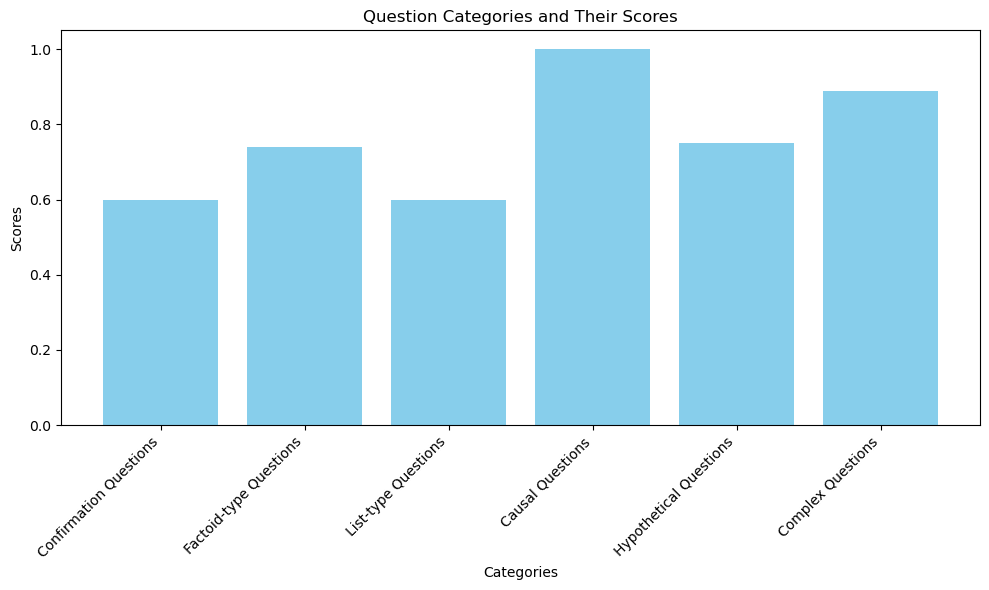

In [46]:
import matplotlib.pyplot as plt
categories = list(t.keys())
values = list(t.values())

plt.figure(figsize=(10, 6))
plt.bar(categories, values, color='skyblue')

# 添加标题和标签
plt.title('Question Categories and Their Scores')
plt.xlabel('Categories')
plt.ylabel('Scores')
plt.xticks(rotation=45, ha='right')  # 旋转分类名称以便更好地阅读

# 显示图表
plt.tight_layout()  # 调整布局，防止标签被切割
plt.show()

In [47]:
TYPE = ['Confirmation Questions', 'Factoid-type Questions', 'List-type Questions', 'Causal Questions',
        'Hypothetical Questions', 'Complex Questions']
t = {TYPE[0]: 0, TYPE[1]: 0, TYPE[2]: 0, TYPE[3]: 0, TYPE[4]: 0, TYPE[5]: 0}
t_base = {TYPE[0]: 0, TYPE[1]: 0, TYPE[2]: 0, TYPE[3]: 0, TYPE[4]: 0, TYPE[5]: 0}
for query, pmid in tqdm(test):
    type = classify(query)
    valid_types = [TYPE[i] for i, val in enumerate(type) if val == 1]
    keywords = query_pre_process(query)
    result_pmids_scores = search(query,  keywords, bm25_abstract, 20,df)
    mask = df2['PMID'].isin(result_pmids_scores)
    df_t = df2[mask]
    texts = df_t['chunk_text'].tolist()
    tokenized_texts = [doc.split() for doc in texts]

    bm25_chunk = BM25(tokenized_texts)
    top_pmids = search(query,  keywords, bm25_chunk, 3,df_t)

    for typ in valid_types:
        t_base[typ] += 1
    if pmid in top_pmids:
        for typ in valid_types:
            t[typ] += 1
for key, val in t.items():
    if t_base[key] != 0:
        t[key] = t[key] / t_base[key]
print(f'recall of bm25 on each type{t}')

  0%|                                                                                                                                                              | 0/50 [00:00<?, ?it/s]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|███                                                                                                                                                   | 1/50 [00:04<04:00,  4.90s/it]Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  4%|██████                               

recall of bm25 on each type{'Confirmation Questions': 0.6, 'Factoid-type Questions': 0.7777777777777778, 'List-type Questions': 0.6, 'Causal Questions': 1.0, 'Hypothetical Questions': 0.75, 'Complex Questions': 0.8888888888888888}


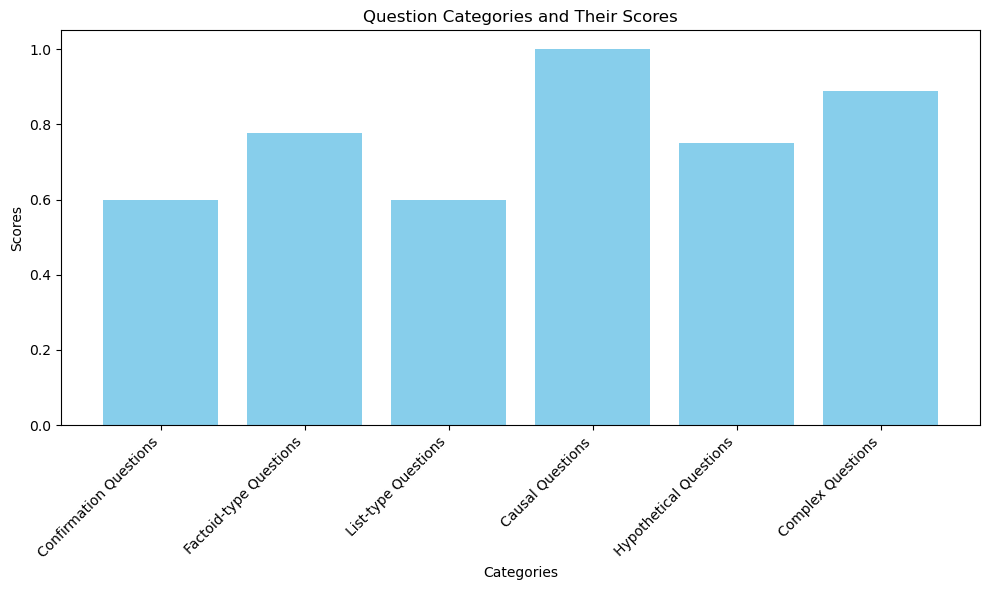

In [48]:
import matplotlib.pyplot as plt
categories = list(t.keys())
values = list(t.values())

plt.figure(figsize=(10, 6))
plt.bar(categories, values, color='skyblue')

# 添加标题和标签
plt.title('Question Categories and Their Scores')
plt.xlabel('Categories')
plt.ylabel('Scores')
plt.xticks(rotation=45, ha='right')  # 旋转分类名称以便更好地阅读

# 显示图表
plt.tight_layout()  # 调整布局，防止标签被切割
plt.show()
